# Prediction of EV Charging station installed in ABQ, NM

## Project Problems




Q1) How many EV cars are per zip code?

Q2) What type of drive chain is the most population based on the existing types between battery electric vehicle (BEV) versus plug-in hybrid electric vehicle (PHEV)?

Note:
We can add more questions based on the data we can find.

## Let's explore the data
From the existing data, we can predict:

- Total Number of EVs per ZIP Code in New Mexico: This is the most direct and crucial piece of information.
  - Knowing which zip codes have a higher concentration of EVs helps in strategically placing charging stations.

- Characteristics of the EV Fleet per ZIP Code: By aggregating features like the average EV model year, or the number of unique EV makes/models.
  - To get a sense of the maturity and diversity of the EV market in a given area.
  - For example, a high average model year might indicate a newer, growing EV population.

- Potential for EV Growth (indirectly): While the current snapshot doesn't directly show growth over time, the presence of newer model year EVs or a high number of unique EV models in a zipcode can indirectly suggest a more active and growing EV market.
  - To truly predict growth, historical data (multiple snapshots over time) would be ideal, allowing for time-series analysis or features like "rate of new EV registrations."
  - The column 'DMV Snapshot ID' provides unique identifier to distinguish DMV snapshots. Index aggregations by this field to create longitudinal data summaries.

## Direction for data processing

To make more beneficial for an EV charging station business, here can be the project focuses (based on the data we have):

1.   Isolate Electric Vehicles: It filters for Drivetrain Type being 'BEV' (Battery Electric Vehicle) or 'PHEV' (Plug-in Hybrid Electric Vehicle).
2.   Predict Total EVs: The machine learning model is now trained to predict the Total EVs per zipcode.
3.  Use EV-Specific Features: The predictive features are now derived from the EV data (e.g., average EV model year, number of unique EV makes/models).


## Expected Outcomes

- We can use the data outcomes from this data processing to taking into consideration the marker growth-driving factors:
  - To answer where we can locate new EV charging stations.
  - what type of chargers should be installed more in the new charging stations for customers' convenience.
  - how can we improve the charging speed of the charger type at the new charging stations (if possible)  

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow.keras as keras
import tensorflow as tf
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn import datasets


## Data Collection/Sources
[State EV Registration](https://www.atlasevhub.com/market-data/state-ev-registration-data/#data)


In [2]:
url = "https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv"
url

'https://a068e7e0.delivery.rocketcdn.me/public/dmv/NM_EV_Registrations_07.csv'

### IDA

In [3]:
!curl -s -I {url} | grep -e HTTP -e Content-

HTTP/2 200 


In [4]:
!curl -s {url} | head -3

State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
"NM","87106","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,7,"DMV Snapshot (5/1/2024)",False
"NM","88012","9/1/2023","TESLA","MODEL 3","2023","BEV","1","Light-Duty (Class 1-2A)",1,1,"DMV Snapshot (10/2/2023)",False


In [5]:
!curl -s {url} | head -1 | tr , '\n' | cat -n

     1	State
     2	ZIP Code
     3	Registration Date
     4	Vehicle Make
     5	Vehicle Model
     6	Vehicle Model Year
     7	Drivetrain Type
     8	Vehicle GVWR Class
     9	Vehicle GVWR Category
    10	Vehicle Count
    11	DMV Snapshot ID
    12	DMV Snapshot (Date)
    13	Latest DMV Snapshot Flag


- Note: Aggregations of these data should be weighted by the values of vehicle count.


In [6]:
!curl -s {url} | wc -l

261172


### Reading in the data

In [7]:
ev_regis_df = pd.read_csv( url )
ev_regis_df.shape

/tmp/ipython-input-1413699084.py:1: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  ev_regis_df = pd.read_csv( url )


(261171, 13)

In [8]:
ev_regis_df.head()

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NM,87106,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,7,DMV Snapshot (5/1/2024),False
1,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,1,DMV Snapshot (10/2/2023),False
2,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,6,DMV Snapshot (4/2/2024),False
3,NM,87031,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,5,DMV Snapshot (3/1/2024),False
4,NM,87544,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,9,DMV Snapshot (7/1/2024),False


In [9]:
# Getting the shape (rows, columns) of the data frame
rows, columns = ev_regis_df.shape
{
  "Rows": rows,
  "Columns" : columns
}

{'Rows': 261171, 'Columns': 13}

In [10]:
# To look at the unique variables in the columns (i = unique values in each column)
for i in ev_regis_df:
  print(i,":", ev_regis_df[i].unique())

State : ['NM']
ZIP Code : [87106 88012 87031 87544 87144 87122 87107 87301 87113 87120 87008 87114
 87505 87501 87124 88005 88011 87507 87111 87109 87506 87105 87102 87110
 87123 87043 87068 87047 87108 87062 88312 88101 88063 87104 87410 88001
 88044 87112 87002 88007 88045 88008 87121 87048 87508 88201 88240 87059
 87116 87015 88242 88310 88021 88314 87801 87020 87547 87529 88002 87825
 87532 88330 88220 88030 88130 88337 88047 87413 88081 88061 87417 87401
 87004 87537 87557 87010 87402 87571 87701 88230 88260 88203 87540 87025
 88024 88415 88345 88352 88210 87901 87035 87715 88072 88401 87415 87016
 87535 88435 87056 87566 87083 88346 87117 87042 87575 87321 87747 88039
 87323 87007 87511 87567 87549 87552 87313 87829 88431 87930 88029 88046
 87551 87562 88041 87347 87522 87519 87548 88325 87053 87827 87026 87583
 87013 87578 87517 87001 87044 88341 87740 87326 87514 88317 88252 88132
 87527 87564 87510 88028 88116 87023 87176 87543 88231 88427 87582 87939
 88232 88042 87556 87103 

In [11]:
ev_regis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261171 entries, 0 to 261170
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   State                     261171 non-null  object
 1   ZIP Code                  261171 non-null  object
 2   Registration Date         261171 non-null  object
 3   Vehicle Make              261171 non-null  object
 4   Vehicle Model             261171 non-null  object
 5   Vehicle Model Year        261171 non-null  int64 
 6   Drivetrain Type           261171 non-null  object
 7   Vehicle GVWR Class        261171 non-null  object
 8   Vehicle GVWR Category     261171 non-null  object
 9   Vehicle Count             261171 non-null  int64 
 10  DMV Snapshot ID           261171 non-null  int64 
 11  DMV Snapshot (Date)       261171 non-null  object
 12  Latest DMV Snapshot Flag  261171 non-null  bool  
dtypes: bool(1), int64(3), object(9)
memory usage: 24.2+ MB


In [12]:
ev_regis_df.describe( include = "all" ).transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,261171,1,NM,261171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP Code,261171.0,390.0,87111.0,10556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration Date,261171,151,8/1/2023,7419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Make,261171,53,TESLA,83285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Model,261171,173,MODEL 3,36686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Model Year,261171.0,NaN,NaN,NaN,2020.707108,3.17735,1993.0,2019.0,2022.0,2023.0,2026.0
Drivetrain Type,261171,2,BEV,175511,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle GVWR Class,261171.0,8.0,1.0,131072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle GVWR Category,261171,4,Light-Duty (Class 1-2A),254466,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle Count,261171.0,NaN,NaN,NaN,1.094214,0.583463,1.0,1.0,1.0,1.0,31.0


In [13]:
ev_regis_df.nunique().sort_values( ascending= False )

,0
ZIP Code,390
Vehicle Model,173
Registration Date,151
Vehicle Make,53
Vehicle Model Year,26
Vehicle Count,26
DMV Snapshot ID,18
DMV Snapshot (Date),18
Vehicle GVWR Class,8
Vehicle GVWR Category,4


### Backup dataframe


In [14]:
ev_df_test1 = ev_regis_df.copy()
ev_df_test1


,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NM,87106,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,7,DMV Snapshot (5/1/2024),False
1,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,1,DMV Snapshot (10/2/2023),False
2,NM,88012,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,6,DMV Snapshot (4/2/2024),False
3,NM,87031,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,5,DMV Snapshot (3/1/2024),False
4,NM,87544,9/1/2023,TESLA,MODEL 3,2023,BEV,1,Light-Duty (Class 1-2A),1,9,DMV Snapshot (7/1/2024),False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261166,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,8,DMV Snapshot (6/1/2024),False
261167,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,16,DMV Snapshot (5/1/2025),False
261168,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,15,DMV Snapshot (4/1/2025),False
261169,NM,87122,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,10,DMV Snapshot (10/3/2024),False


# Direction for data processing

To make more beneficial for an EV charging station business, Here can be the project focus (based on the data we have):

1.   Isolate Electric Vehicles: It filters for Drivetrain Type being 'BEV' (Battery Electric Vehicle) or 'PHEV' (Plug-in Hybrid Electric Vehicle).
2.   Predict Total EVs: The machine learning model is now trained to predict the Total EVs per zipcode.
3.  Use EV-Specific Features: The predictive features are now derived from the EV data (e.g., average EV model year, number of unique EV makes/models).


## Data Cleaning


### Target/ Feature nulls

In [15]:
ev_regis_df.isnull().sum().sort_values(ascending=False)*1000

,0
State,0
ZIP Code,0
Registration Date,0
Vehicle Make,0
Vehicle Model,0
Vehicle Model Year,0
Drivetrain Type,0
Vehicle GVWR Class,0
Vehicle GVWR Category,0
Vehicle Count,0


### Conversion of Data types

- This step will be done later.

## Exploratory Data Analysis


In [16]:
ev_df_test1 = ev_regis_df.copy()

In [17]:
# Ensure 'ZIP Code' is treated as a string to avoid issues with leading zeros
ev_df_test1['ZIP Code'] = ev_df_test1['ZIP Code'].astype(str)

# Sum 'Vehicle Count' for each unique 'ZIP Code'
cars_per_zipcode = ev_df_test1.groupby('ZIP Code')['Vehicle Count'].sum().reset_index()
cars_per_zipcode.rename(columns={'Vehicle Count': 'Total Vehicles'}, inplace=True)


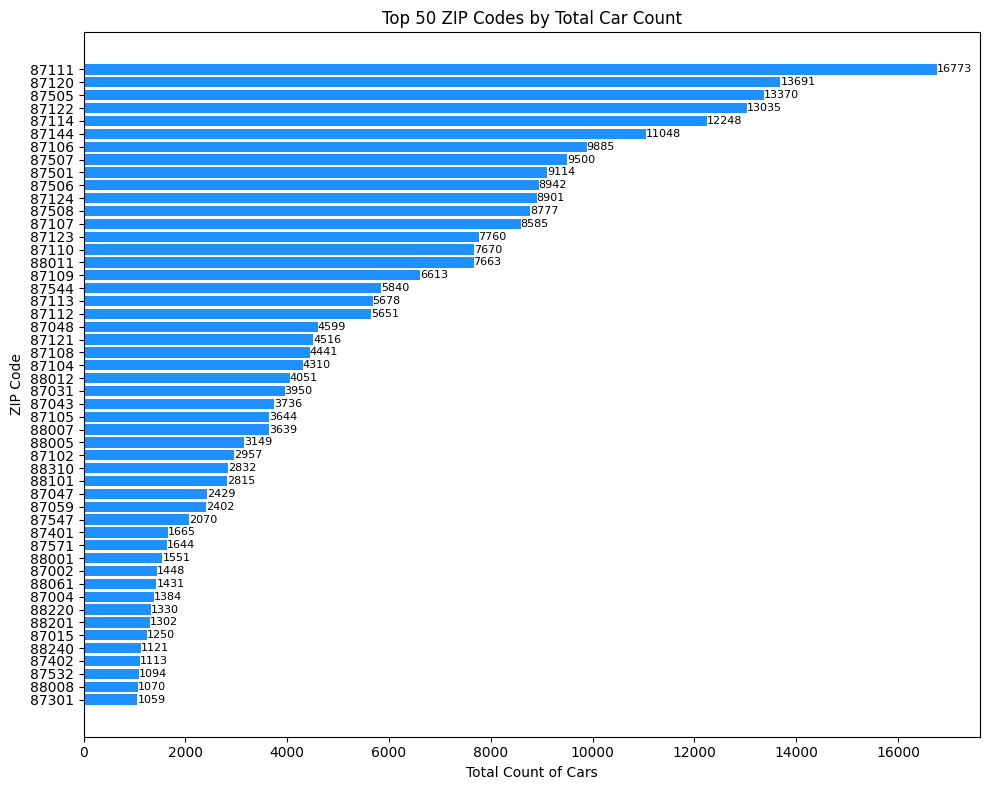

In [18]:
# Plot only the top 50 ZIP codes (since there are too many zip codes in this dataset)
N = 50
top_n_zipcodes = cars_per_zipcode.sort_values(by='Total Vehicles', ascending=False).head(N)
top_n_zipcodes_sorted = top_n_zipcodes.sort_values(by='Total Vehicles', ascending=True) # Sort for plotting order

plt.figure(figsize=(10, 8))
bars = plt.barh(top_n_zipcodes_sorted['ZIP Code'], top_n_zipcodes_sorted['Total Vehicles'], color='dodgerblue')
plt.xlabel('Total Count of Cars')
plt.ylabel('ZIP Code')
plt.title(f'Top {N} ZIP Codes by Total Car Count')
plt.tight_layout()


# Add car count labels on bars
for bar in bars:
    width = bar.get_width()    # Get the width of the bar (which is the car count)
    y_pos = bar.get_y() + bar.get_height() / 2  # Get the y-position of the bar's center
    plt.text(width, y_pos, f'{int(width)}', va='center', ha='left', fontsize=8, color='black')

plt.show()


- The total number of EVs with latest Snapshot (recently updated)

In [19]:
# To select only the latest snapshots by filtering out FALSE in the 'Latest DMV Snapshot Flag' column
# Filter the DataFrame where 'Latest DMV Snapshot Flag' is True
filtered_df = ev_regis_df[ev_regis_df['Latest DMV Snapshot Flag'] == True]
filtered_df

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
30307,NM,87106,3/1/2022,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30308,NM,88101,3/1/2019,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30309,NM,87501,9/1/2023,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30310,NM,87120,9/1/2019,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
30311,NM,87547,12/1/2019,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261098,NM,87505,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True
261107,NM,87507,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True
261116,NM,87112,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True
261121,NM,87120,8/1/2023,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True


In [20]:
filtered_df.shape

(18347, 13)

In [21]:
ev_df_test2 = filtered_df.copy()

In [22]:
# Ensure 'ZIP Code' is treated as a string to avoid issues with leading zeros
ev_df_test2['ZIP Code'] = ev_df_test2['ZIP Code'].astype(str)

# Sum 'Vehicle Count' for each unique 'ZIP Code'
cars_per_zipcode_2 = ev_df_test2.groupby('ZIP Code')['Vehicle Count'].sum().reset_index()
cars_per_zipcode_2.rename(columns={'Vehicle Count': 'Total Vehicles'}, inplace=True)

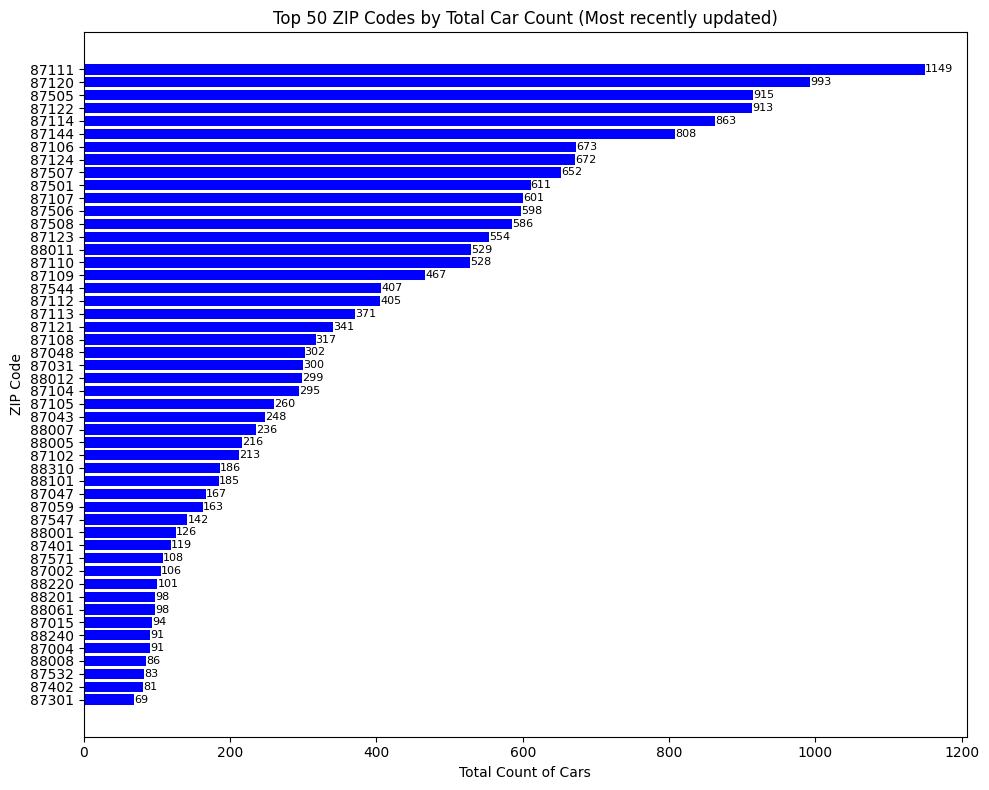

In [23]:
# Plot only the top 50 ZIP codes
N = 50
top_n_zipcodes_2= cars_per_zipcode_2.sort_values(by='Total Vehicles', ascending=False).head(N)
top_n_zipcodes_sorted_2 = top_n_zipcodes_2.sort_values(by='Total Vehicles', ascending=True) # Sort for plotting order

plt.figure(figsize=(10, 8))
bars_updated = plt.barh(top_n_zipcodes_sorted_2['ZIP Code'], top_n_zipcodes_sorted_2['Total Vehicles'], color='blue')
plt.xlabel('Total Count of Cars')
plt.ylabel('ZIP Code')
plt.title(f'Top {N} ZIP Codes by Total Car Count (Most recently updated)')
plt.tight_layout()

# Add car count labels on bars
for bar in bars_updated:
    width = bar.get_width()    # Get the width of the bar (which is the car count)
    y_pos = bar.get_y() + bar.get_height() / 2  # Get the y-position of the bar's center
    plt.text(width, y_pos, f'{int(width)}', va='center', ha='left', fontsize=8, color='black')

plt.show()


# Extraction of Registration Years

In [24]:
from datetime import datetime

In [25]:
# Extract the year from ['Registration Date'] column and create a new column named ['ReleaseYear']
ev_df_test2['Registration Date_temp'] = ev_df_test2['Registration Date'].astype(str).str.strip()

ev_df_test2['Registration Date'] = pd.to_datetime(ev_df_test2['Registration Date'], format='%m/%d/%Y', errors='coerce')
# Find what couldn't be parsed by the first format
#unparsed_mask = ev_df_test2['Registration Date_parsed'].isnull()

# 2. Extract the year into a new column named 'Registration Year'
ev_df_test2['Registration Year'] = ev_df_test2['Registration Date'].dt.year
ev_df_test2['Registration Month'] = ev_df_test2['Registration Date'].dt.month

ev_df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18347 entries, 30307 to 261162
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   State                     18347 non-null  object        
 1   ZIP Code                  18347 non-null  object        
 2   Registration Date         18347 non-null  datetime64[ns]
 3   Vehicle Make              18347 non-null  object        
 4   Vehicle Model             18347 non-null  object        
 5   Vehicle Model Year        18347 non-null  int64         
 6   Drivetrain Type           18347 non-null  object        
 7   Vehicle GVWR Class        18347 non-null  object        
 8   Vehicle GVWR Category     18347 non-null  object        
 9   Vehicle Count             18347 non-null  int64         
 10  DMV Snapshot ID           18347 non-null  int64         
 11  DMV Snapshot (Date)       18347 non-null  object        
 12  Latest DMV Snapsho

In [26]:
ev_df_test2


,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle GVWR Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag,Registration Date_temp,Registration Year,Registration Month
30307,NM,87106,2022-03-01,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True,3/1/2022,2022,3
30308,NM,88101,2019-03-01,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True,3/1/2019,2019,3
30309,NM,87501,2023-09-01,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True,9/1/2023,2023,9
30310,NM,87120,2019-09-01,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True,9/1/2019,2019,9
30311,NM,87547,2019-12-01,TESLA,MODEL 3,2017,BEV,1,Light-Duty (Class 1-2A),1,18,DMV Snapshot (7/1/2025),True,12/1/2019,2019,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261098,NM,87505,2023-08-01,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True,8/1/2023,2023,8
261107,NM,87507,2023-08-01,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True,8/1/2023,2023,8
261116,NM,87112,2023-08-01,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True,8/1/2023,2023,8
261121,NM,87120,2023-08-01,TESLA,MODEL Y,2023,BEV,1,Light-Duty (Class 1-2A),2,18,DMV Snapshot (7/1/2025),True,8/1/2023,2023,8


In [27]:
ev_df_test2.isnull().sum()

,0
State,0
ZIP Code,0
Registration Date,0
Vehicle Make,0
Vehicle Model,0
Vehicle Model Year,0
Drivetrain Type,0
Vehicle GVWR Class,0
Vehicle GVWR Category,0
Vehicle Count,0


In [28]:
# Create a new dataframe: Total cars in each year
ev_zip_and_year = ev_df_test2[['ZIP Code','Vehicle Count','Registration Year']]
ev_zip_and_year

,ZIP Code,Vehicle Count,Registration Year
30307,87106,1,2022
30308,88101,1,2019
30309,87501,1,2023
30310,87120,1,2019
30311,87547,1,2019
...,...,...,...
261098,87505,2,2023
261107,87507,2,2023
261116,87112,2,2023
261121,87120,2,2023


In [29]:
cars_by_zip_and_year_sorted = ev_zip_and_year.sort_values(by=['ZIP Code', 'Registration Year']).reset_index(drop=True)



print("DataFrame to compare:")
print(cars_by_zip_and_year_sorted.head(10)) # Displaying first 10 rows

DataFrame to compare:
  ZIP Code  Vehicle Count  Registration Year
0    33309              1               2024
1    60016              1               2024
2    60016              1               2024
3    60016              1               2025
4    60048              1               2025
5    87001              1               2023
6    87001              1               2023
7    87001              1               2024
8    87001              1               2024
9    87001              1               2024


In [30]:
# Group by 'ZIP Code' and 'Registration Year' and sum 'Vehicle Count'
cars_by_zip_and_year = ev_df_test2.groupby(['ZIP Code', 'Registration Year'])['Vehicle Count'].sum().reset_index()

# Rename the column for clarity
cars_by_zip_and_year.rename(columns={'Vehicle Count': 'Total Cars'}, inplace=True)

# Display the result
print("Total cars grouped by ZIP Code and Registration Year:")
print(cars_by_zip_and_year)

# You might want to sort it for better readability
cars_by_zip_and_year_sorted = cars_by_zip_and_year.sort_values(by=['ZIP Code', 'Registration Year']).reset_index(drop=True)
print("\nSorted results:")
print(cars_by_zip_and_year_sorted)

Total cars grouped by ZIP Code and Registration Year:
     ZIP Code  Registration Year  Total Cars
0       33309               2024           1
1       60016               2024           2
2       60016               2025           1
3       60048               2025           1
4       87001               2023           2
...       ...                ...         ...
1022    88435               2022           3
1023    88435               2023           1
1024    88435               2024           3
1025    88435               2025           2
1026    97209               2024           2

[1027 rows x 3 columns]

Sorted results:
     ZIP Code  Registration Year  Total Cars
0       33309               2024           1
1       60016               2024           2
2       60016               2025           1
3       60048               2025           1
4       87001               2023           2
...       ...                ...         ...
1022    88435               2022           3
1023

In [31]:
# Pivot table with ZIP codes as rows and Years as columns
pivot_table = cars_by_zip_and_year_sorted.pivot_table(
    index='ZIP Code',
    columns='Registration Year',
    values='Total Cars',
    fill_value=0 # Fill years with no data for a ZIP code with 0
)

print("\nPivot Table: Total Cars by ZIP Code (rows) and Year (columns)")
print(pivot_table)


Pivot Table: Total Cars by ZIP Code (rows) and Year (columns)
Registration Year  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  \
ZIP Code                                                                        
33309               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
60016               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
60048               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
87001               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
87002               0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   3.0   5.0   
...                 ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
88427               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
88431               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
88434               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
88435               0.0   0.0   0.0   0.0   0.

Reference for zip codes in ABQ:

[GISGeography](https://gisgeography.com/albuquerque-zip-code-map/)

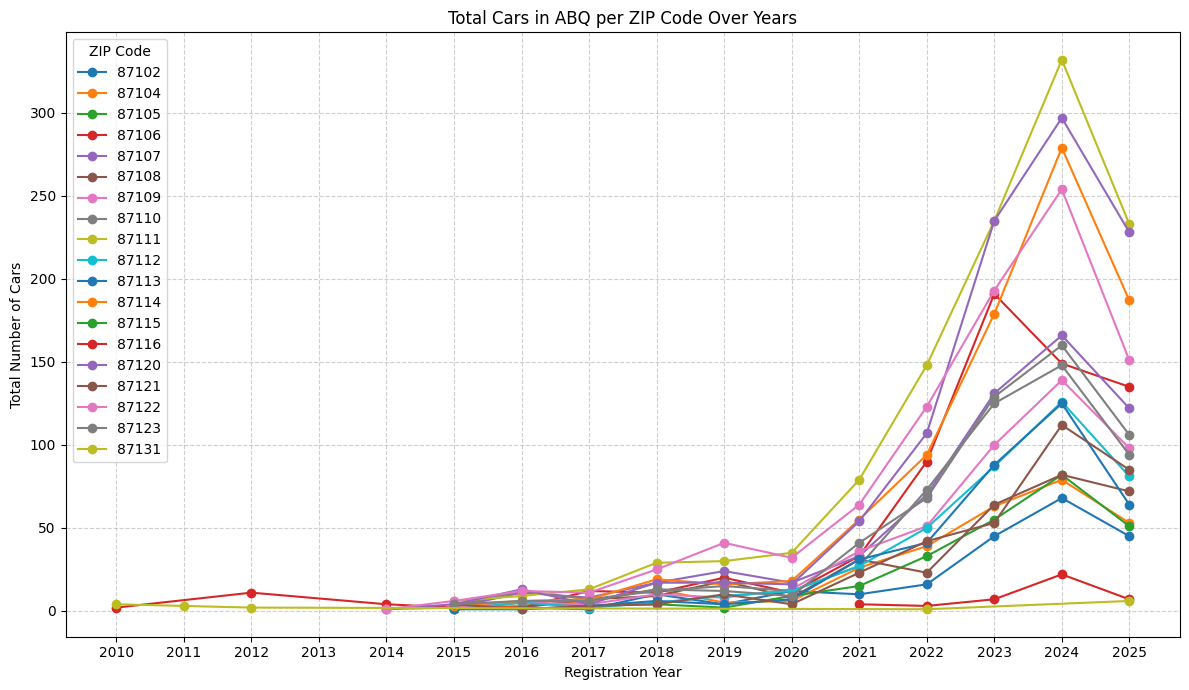

In [32]:
zip_abq = ['87102','87104','87105','87106','87107','87108','87109','87110','87111','87112','87113','87114','87115','87116', '87120', '87121', '87122', '87123','87131']

plt.figure(figsize=(12, 7))

# Select a few ZIP codes to plot
#zip_codes_to_plot = cars_by_zip_and_year_sorted['ZIP Code'].value_counts().nlargest(20).index.tolist() # Top 20 ZIPs by total cars

for zip_code in zip_abq:
    subset = cars_by_zip_and_year_sorted[cars_by_zip_and_year_sorted['ZIP Code'] == zip_code]
    plt.plot(subset['Registration Year'], subset['Total Cars'], marker='o', label={zip_code})

plt.xlabel('Registration Year')
plt.ylabel('Total Number of Cars')
plt.title('Total Cars in ABQ per ZIP Code Over Years')
plt.xticks(cars_by_zip_and_year_sorted['Registration Year'].unique().astype(int)) # Ensure integer years on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='ZIP Code')
plt.tight_layout()
plt.show()

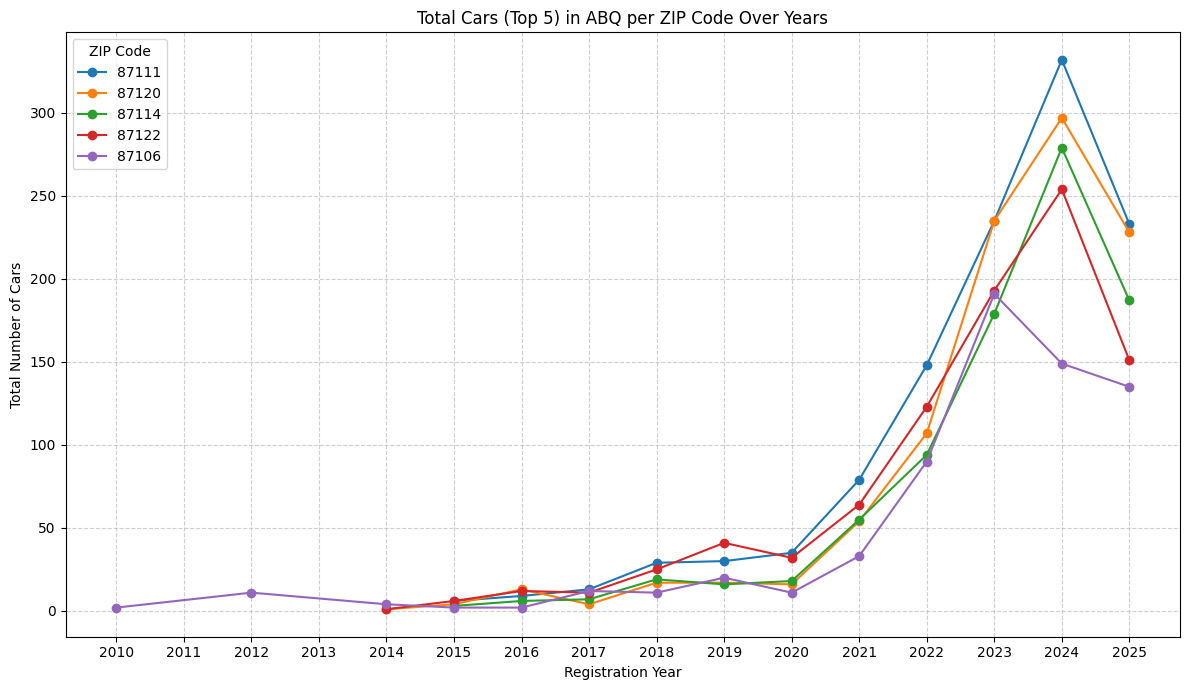

In [33]:
zip_abq_5 = ['87111', '87120', '87114', '87122', '87106']

plt.figure(figsize=(12, 7))

# Select a few ZIP codes to plot
#zip_codes_to_plot = cars_by_zip_and_year_sorted['ZIP Code'].value_counts().nlargest(20).index.tolist() # Top 20 ZIPs by total cars

for zip_code in zip_abq_5:
    subset2 = cars_by_zip_and_year_sorted[cars_by_zip_and_year_sorted['ZIP Code'] == zip_code]
    plt.plot(subset2['Registration Year'], subset2['Total Cars'], marker='o', label={zip_code})

plt.xlabel('Registration Year')
plt.ylabel('Total Number of Cars')
plt.title('Total Cars (Top 5) in ABQ per ZIP Code Over Years')
plt.xticks(cars_by_zip_and_year_sorted['Registration Year'].unique().astype(int)) # Ensure integer years on x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='ZIP Code')
plt.tight_layout()
plt.show()

## Data Processing
- To perform time series analysis used to predict the trend of EV users number changing over time from August 2025 to July 2026.

## ARIMA model

### Data Preparation

In [34]:
import sys
!{sys.executable} -m pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.2 MB/s eta 0:00:00


In [35]:
#import pandas as pd
#import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
# Group by 'ZIP Code' and 'Registration Year' and sum 'Vehicle Count'
# Create a new dataframe named ev_by_zip_month_year
ev_by_zip_month_year = ev_df_test2.groupby(['ZIP Code', 'Registration Date', 'Registration Year'])['Vehicle Count'].sum().reset_index()
ev_by_zip_month_year

,ZIP Code,Registration Date,Registration Year,Vehicle Count
0,33309,2024-05-01,2024,1
1,60016,2024-12-01,2024,2
2,60016,2025-01-01,2025,1
3,60048,2025-06-01,2025,1
4,87001,2023-09-01,2023,1
...,...,...,...,...
4750,88435,2024-07-01,2024,1
4751,88435,2024-10-01,2024,1
4752,88435,2025-02-01,2025,1
4753,88435,2025-05-01,2025,1


In [38]:
ev_by_zip_month_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4755 entries, 0 to 4754
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ZIP Code           4755 non-null   object        
 1   Registration Date  4755 non-null   datetime64[ns]
 2   Registration Year  4755 non-null   int32         
 3   Vehicle Count      4755 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 130.1+ KB


In [39]:
# Define the list of ABQ Zip Codes (same as above)
zip_abq = ['87102', '87104', '87105', '87106', '87107', '87108', '87109', '87110',
                 '87111', '87112', '87113', '87114', '87115', '87116', '87120',
                 '87121', '87122', '87123', '87131']

In [40]:
# Filter the DataFrame to include only the specified zip codes
# The `.isin()` method checks if each element in the 'ZIP Code' column is present in the `abq_zip_codes` list.
# The result is a boolean Series that we use to filter the DataFrame.
abq_month_year_df = ev_by_zip_month_year[ev_by_zip_month_year['ZIP Code'].isin(zip_abq)].copy()

In [41]:
# Create a new column named "ABQ Zip Code"
# In this case, we can simply assign the 'ZIP Code' column since we've already filtered.
abq_month_year_df['ABQ Zip Code'] = abq_month_year_df['ZIP Code']

In [42]:
# drop the old 'ZIP Code' column
abq_month_year_df.drop(columns=['ZIP Code'], inplace=True)
abq_month_year_df

,Registration Date,Registration Year,Vehicle Count,ABQ Zip Code
707,2016-06-01,2016,1,87102
708,2016-07-01,2016,1,87102
709,2017-02-01,2017,1,87102
710,2018-03-01,2018,1,87102
711,2018-05-01,2018,1,87102
...,...,...,...,...
2233,2011-12-01,2011,1,87131
2234,2012-08-01,2012,1,87131
2235,2012-09-01,2012,1,87131
2236,2022-07-01,2022,1,87131


In [43]:
abq_month_year_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1416 entries, 707 to 2237
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Registration Date  1416 non-null   datetime64[ns]
 1   Registration Year  1416 non-null   int32         
 2   Vehicle Count      1416 non-null   int64         
 3   ABQ Zip Code       1416 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 49.8+ KB


- To plot the total EV users over year

In [44]:
# 1. Group the data by 'Registration Year' and sum the 'Vehicle Count' for each year.
# This gives us the total number of vehicles registered in each year.
car_counts_year = abq_month_year_df.groupby('Registration Year')['Vehicle Count'].sum()

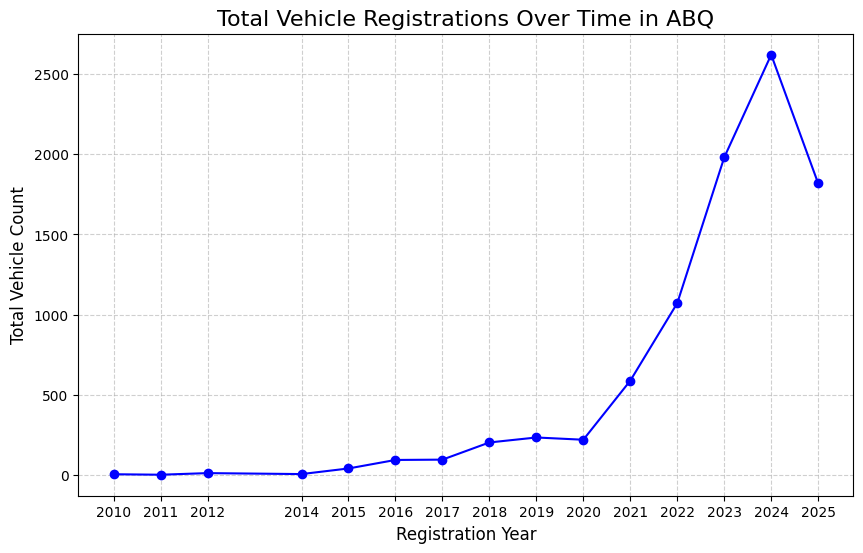

In [45]:
# 2. Create the line plot using matplotlib.
# We'll use the year as the x-axis and the total vehicle count as the y-axis.
plt.figure(figsize=(10, 6)) # Set the figure size for better readability
plt.plot(car_counts_year.index, car_counts_year.values, marker='o', linestyle='-', color='b')

# 3. Add titles and labels to the plot for clarity.
plt.title('Total Vehicle Registrations Over Time in ABQ', fontsize=16)
plt.xlabel('Registration Year', fontsize=12)
plt.ylabel('Total Vehicle Count', fontsize=12)
plt.xticks(car_counts_year.index) # Ensure all years are shown on the x-axis
plt.grid(True, linestyle='--', alpha=0.6) # Add a grid for easier reading

plt.show()

### Create Model

In [46]:
#!pip install --upgrade numpy pmdarima --force-reinstall

In [47]:
#from pmdarima import auto_arima

In [48]:
ev_arima = abq_month_year_df.copy()
ev_arima.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1416 entries, 707 to 2237
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Registration Date  1416 non-null   datetime64[ns]
 1   Registration Year  1416 non-null   int32         
 2   Vehicle Count      1416 non-null   int64         
 3   ABQ Zip Code       1416 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 49.8+ KB


In [49]:
# Step 1: Set 'Registration Date' as the DataFrame index (for time series operations):
ev_arima_ts = ev_arima.set_index('Registration Date')

In [50]:
ev_arima_ts

,Registration Year,Vehicle Count,ABQ Zip Code
Registration Date,,,
2016-06-01,2016,1,87102
2016-07-01,2016,1,87102
2017-02-01,2017,1,87102
2018-03-01,2018,1,87102
2018-05-01,2018,1,87102
...,...,...,...
2011-12-01,2011,1,87131
2012-08-01,2012,1,87131
2012-09-01,2012,1,87131


### Training Model

Workflow:
1. Training Data: 2010 to 2024 (inclusive).

2. Testing Data (for evaluation): January 2025 to July 2025.

3. Future Prediction: August 2025 to July 2026.

In [51]:
# 2. Define the date ranges for training, testing, and forecasting
training_start_date = '2020-01-01'
training_end_date = '2024-07-31'
testing_start_date = '2024-08-01'
testing_end_date = '2025-07-01'
forecast_start_date = '2025-08-01'
forecast_end_date = '2026-07-31'

# 3. Get the number of periods to forecast
# Calculate the number of months between the start and end date
forecast_periods = pd.to_datetime(forecast_end_date).to_period('M').to_timestamp() - pd.to_datetime(forecast_start_date).to_period('M').to_timestamp()
forecast_periods = int(forecast_periods / pd.Timedelta(days=30)) + 1

# 4. Get the unique zip codes to iterate through
zip_codes = ev_arima_ts['ABQ Zip Code'].unique()

Processing Zip Code: 87102


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87104


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87105


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Processing Zip Code: 87106


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87107


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87108


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87109


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87110


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87111


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87112


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Zip Code: 87113


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87114


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87116


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Zip Code: 87120


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87121


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


Processing Zip Code: 87122


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Processing Zip Code: 87123
Processing Zip Code: 87131


/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/tmp/ipython-input-1330463517.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)


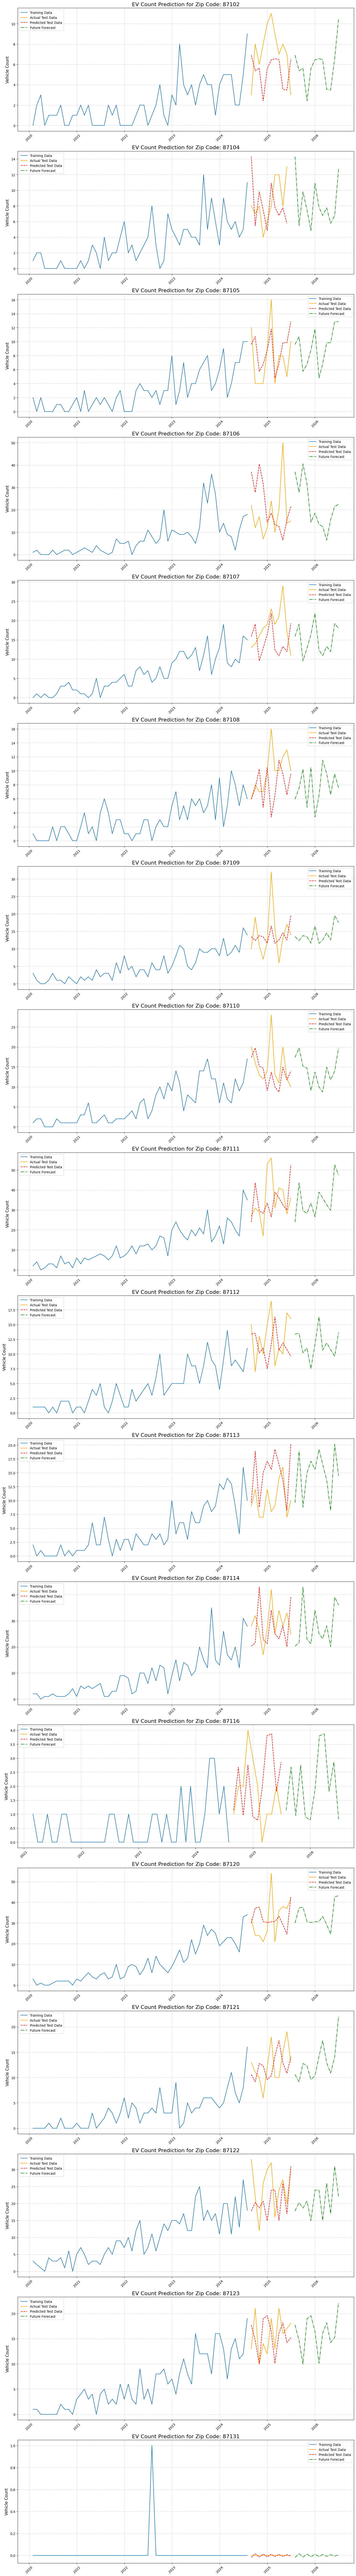

In [52]:
# Create a figure to hold all subplots
fig, axes = plt.subplots(len(zip_codes), 1, figsize=(15, 6 * len(zip_codes)), sharex=False)
if len(zip_codes) == 1:
    axes = [axes] # Ensure axes is an iterable for the loop

# 5. Loop through each zip code to build and forecast the ARIMA model
for i, zip_code in enumerate(zip_codes):
    print(f"Processing Zip Code: {zip_code}")

    # a. Filter the DataFrame for the current zip code
    zip_df = ev_arima_ts[ev_arima_ts['ABQ Zip Code'] == zip_code]

    # b. Resample the data to a monthly frequency and sum the vehicle counts
    # This creates a time series with a regular interval.
    zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)

    # c. Split the data into training and testing sets
    train_data = zip_series.loc[training_start_date:training_end_date]
    test_data = zip_series.loc[testing_start_date:testing_end_date]

    # d. Manually specify the ARIMA model parameters (p, d, q) and fit the model.
    # p: The number of lag observations included in the model.
    # d: The number of times the raw observations are differenced.
    # q: The size of the moving average window.
    # A common starting point is ARIMA(1,1,1). We'll use a slightly more complex (2,1,2) here.
    try:
        model = ARIMA(train_data, order=(2, 1, 2), seasonal_order=(0,1,0,12)).fit()
    except Exception as e:
        print(f"Error fitting ARIMA model for {zip_code}: {e}")
        continue # Skip to the next zip code if an error occurs.

    # e. Make predictions on the test set and a future forecast
    # The `forecast` method is used in the `statsmodels` library.
    test_predictions = model.forecast(steps=len(test_data))
    forecast = model.forecast(steps=forecast_periods)

    # f. Create a combined series for plotting the forecast
    forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_periods, freq='MS')
    forecast_series = pd.Series(forecast.values, index=forecast_index)

    # g. Plot the results for the current zip code
    ax = axes[i]
    ax.set_title(f'EV Count Prediction for Zip Code: {zip_code}', fontsize=16)
    ax.plot(train_data, label='Training Data')
    ax.plot(test_data, label='Actual Test Data', color='orange')
    ax.plot(test_predictions.index, test_predictions.values, label='Predicted Test Data', color='red', linestyle='--')
    ax.plot(forecast_series, label='Future Forecast', color='green', linestyle='-.')
    ax.set_ylabel('Vehicle Count', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


## ARIMA Part 2

### Using Auto_ARIMA: Problem is I cannot import auto_arima

In [53]:
#pip uninstall pmdarima numpy

In [54]:
#!pip install numpy==1.24.4  # Or a similar known-good version

In [55]:
!pip install pmdarima

In [58]:
!python -m venv myenv

Error: Command '['/content/myenv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima # Import auto_arima again for automatic parameter selection
import warnings
warnings.filterwarnings("ignore") # Ignore harmless warnings


# 1. Prepare the data: set 'Registration Date' as the index
df = df.set_index('Registration Date')

# 2. Define the date ranges for training, testing, and forecasting
training_start_date = '2020-01-01'
training_end_date = '2024-07-01'
testing_start_date = '2024-08-01'
testing_end_date = '2025-07-01'
forecast_start_date = '2025-08-01'
forecast_end_date = '2026-07-01'

# 3. Get the number of periods to forecast
# We calculate the number of months between the start and end date
forecast_periods = pd.to_datetime(forecast_end_date).to_period('M').to_timestamp() - pd.to_datetime(forecast_start_date).to_period('M').to_timestamp()
forecast_periods = int(forecast_periods / pd.Timedelta(days=30)) + 1

# 4. Get the unique zip codes to iterate through
zip_codes = df['ABQ Zip Code'].unique()

# Create a figure to hold all subplots
fig, axes = plt.subplots(len(zip_codes), 1, figsize=(15, 6 * len(zip_codes)), sharex=False)
if len(zip_codes) == 1:
    axes = [axes] # Ensure axes is an iterable for the loop

# 5. Loop through each zip code to build and forecast the ARIMA model
for i, zip_code in enumerate(zip_codes):
    print(f"Processing Zip Code: {zip_code}")

    # a. Filter the DataFrame for the current zip code
    zip_df = df[df['ABQ Zip Code'] == zip_code]

    # b. Resample the data to a monthly frequency and sum the vehicle counts
    # This creates a time series with a regular interval.
    zip_series = zip_df.resample('M')['Vehicle Count'].sum().fillna(0)

    # c. Split the data into training and testing sets
    # This is the corrected line. Note the parentheses around each condition.
    train_data = zip_series.loc[training_start_date:training_end_date]
    test_data = zip_series.loc[testing_start_date:testing_end_date]

    # d. Use auto_arima to find the best ARIMA model parameters
    # The seasonal=True argument is important for monthly data.
    try:
        model = auto_arima(
            train_data,
            start_p=1, start_q=1, max_p=3, max_q=3, m=12,
            start_P=0, seasonal=True, d=1, D=1, trace=True,
            error_action='ignore', suppress_warnings=True, stepwise=True
        )
    except Exception as e:
        print(f"Error fitting auto_arima model for {zip_code}: {e}")
        continue # Skip to the next zip code if an error occurs.

    # e. Make predictions on the test set and a future forecast
    # The `predict` method is used in the `pmdarima` library.
    test_predictions = model.predict(n_periods=len(test_data))
    forecast = model.predict(n_periods=forecast_periods)

    # f. Create a combined series for plotting the forecast
    forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_periods, freq='MS')
    forecast_series = pd.Series(forecast, index=forecast_index)

    # g. Plot the results for the current zip code
    ax = axes[i]
    ax.set_title(f'EV Count Prediction for Zip Code: {zip_code}', fontsize=16)
    ax.plot(train_data, label='Training Data')
    ax.plot(test_data, label='Actual Test Data', color='orange')
    ax.plot(test_predictions.index, test_predictions.values, label='Predicted Test Data', color='red', linestyle='--')
    ax.plot(forecast_series, label='Future Forecast', color='green', linestyle='-.')
    ax.set_ylabel('Vehicle Count', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

### Create Training data

In [ ]:
trn = ev_arima_ts.loc[(ev_arima_ts.index > '2020-01-01') & (ev_arima_ts.index < '2024-07-01')]

In [ ]:
fig, ax = plt.subplots()
plt.xlabel('Jan 2020 - Jul 2024')
plt.ylabel('Monthly EV Counts')
plt.title('Monthly EV Counts Over Time')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))